<a href="https://colab.research.google.com/github/Ayanlola2002/DATA-SCIENCE-PROJECTS/blob/master/AppDownload_XGBoost_Modeling(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Note:
# Created and using “bn-book ipynb” notebook
# Instance of ml.t2.medium except when running predictions
# IAM role for SageMaker
# Download (DL) xgboost modeling

from sagemaker import get_execution_role

In [0]:
# Set IAM role and S3 bucket where train data is

role = get_execution_role() # IAM from notebook instance
bucket_name = 'tundesbucket' # S3 bucket of train data

In [0]:
# import libraries

from IPython.display import display               
from IPython.display import Image
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer

In [0]:
# import more libraries

import numpy as np
import sagemaker, math, boto3, os, json, urllib.request, re, sys                               
import pandas as pd                               
import matplotlib.pyplot as plt                   
import numpy, urllib.request, json

In [0]:
# Set up containers for XGBoost
# Note that there might be bucket creation error cause this code might have ran more than once with bucket created the 1st time

prefix = 'sagemaker/all_dl-xgboost-dm' # Place holder for prefix
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
             'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
             'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
             'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # xgboost container for regions

all_dl_region = boto3.session.Session().region_name # set the region of the instance
print("SageMaker instance is in the " + all_dl_region + " region. Use " + containers[all_dl_region] + " container as SM endpoint.")

# Create S3 bucket for Training Data

s3 = boto3.resource('s3')
try:
    if  all_dl_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else: 
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': all_dl_region })
    print('Train bucket created!')
except Exception as e:
    print('Train bucket creation issue: ',e)

SageMaker instance is in the us-west-2 region. Use 433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest container as SM endpoint.
Train bucket created!


In [0]:
# Load data into a notebook dataframe for modeling

try:
#  model_data = pd.read_csv('s3://baotraindata/run-1539650615693-part-r-00000.cvs')
    model_data = pd.read_csv('s3://singleapp1/new_train_data_set(1).csv') #Location of the csv with data
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [0]:
# Set 70% for train input data and the rest, 20%, for model validation and 10% for test prediction

train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

# Confirm the data splits

print(train_data.shape, validation_data.shape, test_data.shape)

(7030, 5) (2009, 5) (1005, 5)


In [0]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 5 columns):
conversion    10044 non-null int64
uid           10044 non-null object
a1            10044 non-null float64
a2            5226 non-null float64
a3            3567 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 392.4+ KB


In [0]:
# Check the train data before changing them

train_data.info(), validation_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7030 entries, 9708 to 5343
Data columns (total 5 columns):
conversion    7030 non-null int64
uid           7030 non-null object
a1            7030 non-null float64
a2            3648 non-null float64
a3            2496 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 329.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 9721 to 4695
Data columns (total 5 columns):
conversion    2009 non-null int64
uid           2009 non-null object
a1            2009 non-null float64
a2            1058 non-null float64
a3            716 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 94.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 932 to 1677
Data columns (total 5 columns):
conversion    1005 non-null int64
uid           1005 non-null object
a1            1005 non-null float64
a2            520 non-null float64
a3            355 non-null float64
dtypes: float64(3),

(None, None, None)

In [0]:
# Saving a copy of all original data set with User_id for matching and analysis later

train_data.to_csv('train_data_uid')
validation_data.to_csv('validation_data_uid')
test_data.to_csv('test_data_uid')

# - Deleting string columns

train_data = train_data.drop(columns=['uid'])
validation_data = validation_data.drop(columns=['uid'])
test_data = test_data.drop(columns=['uid'])

In [0]:
# Remove header and index

train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

In [0]:
train_data.info(), validation_data.info(), test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7030 entries, 9708 to 5343
Data columns (total 4 columns):
conversion    7030 non-null int64
a1            7030 non-null float64
a2            3648 non-null float64
a3            2496 non-null float64
dtypes: float64(3), int64(1)
memory usage: 274.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 9721 to 4695
Data columns (total 4 columns):
conversion    2009 non-null int64
a1            2009 non-null float64
a2            1058 non-null float64
a3            716 non-null float64
dtypes: float64(3), int64(1)
memory usage: 78.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005 entries, 932 to 1677
Data columns (total 4 columns):
conversion    1005 non-null int64
a1            1005 non-null float64
a2            520 non-null float64
a3            355 non-null float64
dtypes: float64(3), int64(1)
memory usage: 39.3 KB


(None, None, None)

In [0]:
# Upload the training and validation datasets
try:
    boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
    boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
    print("Success")
except Exception as e:
    print('Data load error: ',e)

Success


In [0]:
# Set the train files location
try:
    s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation'.format(bucket_name, prefix), content_type='csv')
except Exception as e:
    print('Data load error: ',e)

In [0]:
# SM xgboost session and parameters. These can be tuned later as needed

sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(containers[all_dl_region],role, train_instance_count=1, train_instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

In [0]:
# Train the model

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

AttributeError: 'Estimator' object has no attribute 'train_volume_kms_key'

In [0]:
# deploys model to Amazon SageMaker hosting. It takes a few minutes to set up the hosting endpoint.

xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2018-10-29-23-51-28-801
INFO:sagemaker:Creating endpoint with name xgboost-2018-10-29-23-48-04-931


------------------------------------------------------------------------------!

## Making predictions

In [0]:
# Time to make predictions. First set up the serializer.
# This takes numpy arrays (like the testing data) and serializes them to CSV format.

xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

# Then define a predict function that will take in testing data as input and run predictions on the data.
# This is done through the xgb_predictor.predict() function call.

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

train_predictions = predict(train_data.as_matrix()[:, 1:])
test_predictions = predict(test_data.as_matrix()[:, 1:])

# The output is an array with predictions. The first element of the array is the probability that
# the corresponding first input row will convert or download the app.

# Now that the model is hosted, one can start to make predictions about which row will convert.
# This allows the sorting of highest probability to convert.

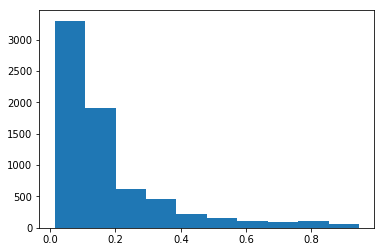

In [0]:
# Check out the prediction histogram

plt.hist(train_predictions)
plt.show()

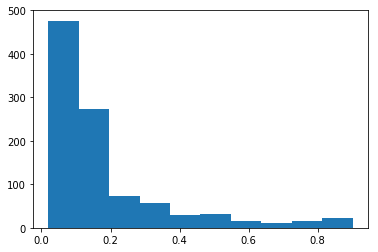

In [0]:
plt.hist(test_predictions)
plt.show()

In [0]:
#RS - predictions on train and test portion
train_pred = pd.DataFrame(train_predictions)

train_pred.loc[train_pred[0] < 0.5, 0] = 0
train_pred.loc[train_pred[0] >= 0.5, 0] = 1

test_pred = pd.DataFrame(test_predictions)

test_pred.loc[test_pred[0] < 0.5, 0] = 0
test_pred.loc[test_pred[0] >= 0.5, 0] = 1

## Accuracy of the training set

In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(train_data.as_matrix()[:, 0], train_pred.values))

[[5666   91]
 [ 881  392]]


In [0]:
from sklearn.metrics import classification_report
print(classification_report(train_data.as_matrix()[:, 0], train_pred.values))

             precision    recall  f1-score   support

        0.0       0.87      0.98      0.92      5757
        1.0       0.81      0.31      0.45      1273

avg / total       0.86      0.86      0.84      7030



## Accuracy of the test set

In [0]:
print(confusion_matrix(test_data.as_matrix()[:, 0], test_pred.values))

[[802  25]
 [120  58]]


In [0]:
print(classification_report(test_data.as_matrix()[:, 0], test_pred.values))

             precision    recall  f1-score   support

        0.0       0.87      0.97      0.92       827
        1.0       0.70      0.33      0.44       178

avg / total       0.84      0.86      0.83      1005



## Shutting down the endpoint to avoid unnecessary charges

In [0]:
# Shutting down everything

sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
# bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
# bucket_to_delete.objects.all().delete()

INFO:sagemaker:Deleting endpoint with name: xgboost-2018-10-29-23-48-04-931
